# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
import pyppeteer


EPS = 1.0e-7

In [2]:
# # IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# # mount drive: WE NEED IT FOR SAVING IMAGES!
# from google.colab import drive

# drive.mount("/content/gdrive")

In [3]:
# # IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# # PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
# results_dir = "/content/gdrive/My_Drive/Colab Notebooks/TEACHING/"

In [2]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

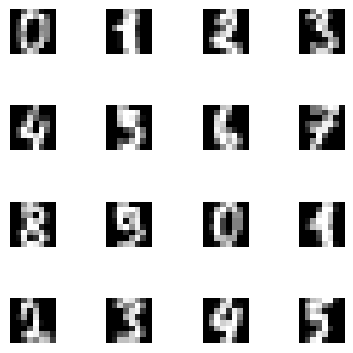

In [3]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [4]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).

# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [5]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
# =========
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # ------
        # PLEASE FILL IN
        # y_pred = ...

        #this is the output of x after sequential module with layers and activations
        output = self.classnet(x)
        #we define the activation as log softmax and will see it as log probabilities
        activation_p = F.log_softmax(output, dim=1)
        #the class with the max log probability is assigned to x
        _, y_pred = torch.max(activation_p, dim=1)

        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        # ------
        # PLEASE FILL IN
        # loss = ...

        #this is the output of x after sequential module with layers and activations
        output = self.classnet(x)
        #we define the activation as log softmax and will see it as log probabilities
        activation_p = F.log_softmax(output, dim=1)
        #compute the loss using the negative log-likelihood
        loss =  self.nll(activation_p, y.long())

        # ------
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:**
The objective function for a classification task is the negative log likelihood loss, in code it is nn.NLLLoss. 

In mathematical terms:

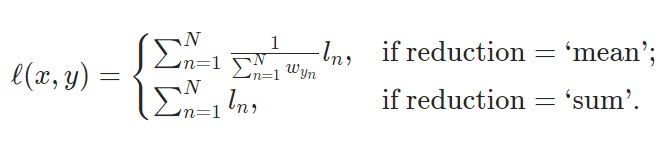

source: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

Explanation:
- overall the idea is to calculate the difference between the predicted probabilities of each class and the actual (correct) class. Taking the -log of the predicted probability ensures that the objective function penalizes the model more for incorrect predictions.
- sum: sum the individual losses for each sample, then for each sample calculate the negative logarithm of the predicted probability assigned to the class, add up all individual losses for all samples.
- mean: average the individual losses for each sample, then for each sample calculate the negative logarithm of the predicted probability assigned to the class, add up all individual losses and divide by the number of samples.

For example:

NLLLoss = -1/N * sum(log(p,y))
- N is the total number of samples
- p and y is the predicted probability and the target label accordingly

**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** 
The answer is yes, it is correct to use the logarithm of the softmax function when computing the negative log-likelihood loss as the final activation function in the neural network classifier. The reasoning behind this is that even though softmax converts values into log-probabilities, the min/max indexes and relative order of the probabilities remains the same in both cases- whether you use softmax or log-softmax. In some examples the log-softmax implementation is benefitial since it ensures stability and efficiency. 

### 2.2 Evaluation

In [6]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

### 2.3 Training procedure

In [7]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [8]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [9]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
print(f"Feature example shape: {train_data[1][0].shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [10]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1, 8, 8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [11]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=0.7176536669049944, val ce=0.16285714285714287
Epoch: 10, val nll=0.10378172057015556, val ce=0.03428571428571429
Epoch: 20, val nll=0.10017034121922085, val ce=0.037142857142857144
Epoch: 30, val nll=0.09178535665784564, val ce=0.037142857142857144
Epoch: 40, val nll=0.09313352244240897, val ce=0.03428571428571429
-> FINAL PERFORMANCE: nll=0.2910099765598374, ce=0.07606263982102908


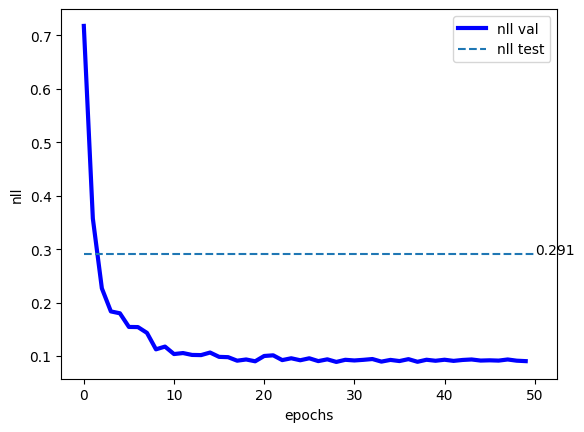

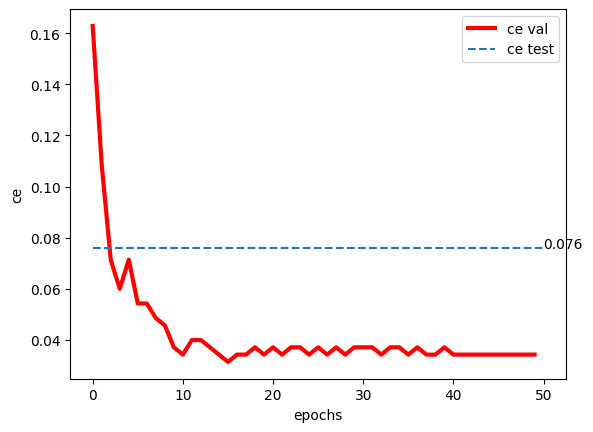


-> START classifier_cnn
Epoch: 0, val nll=0.7704745755876814, val ce=0.16857142857142857
Epoch: 10, val nll=0.12387316363198417, val ce=0.025714285714285714
Epoch: 20, val nll=0.07382188967296055, val ce=0.02
Epoch: 30, val nll=0.06533256156103952, val ce=0.017142857142857144
Epoch: 40, val nll=0.05943290761538914, val ce=0.017142857142857144
Epoch: 50, val nll=0.051259253706250875, val ce=0.014285714285714285
Epoch: 60, val nll=0.049044396281242374, val ce=0.014285714285714285
Epoch: 70, val nll=0.045637781534876146, val ce=0.014285714285714285
Epoch: 80, val nll=0.04349785242761885, val ce=0.014285714285714285
Epoch: 90, val nll=0.04238700747489929, val ce=0.014285714285714285
Epoch: 100, val nll=0.042712358406611854, val ce=0.014285714285714285
Epoch: 110, val nll=0.04088061217750822, val ce=0.014285714285714285
Epoch: 120, val nll=0.039301856713635584, val ce=0.014285714285714285
Epoch: 130, val nll=0.03896639798368726, val ce=0.014285714285714285
-> FINAL PERFORMANCE: nll=0.25322

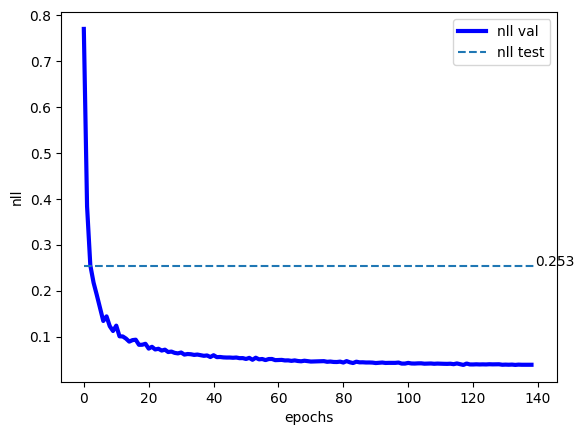

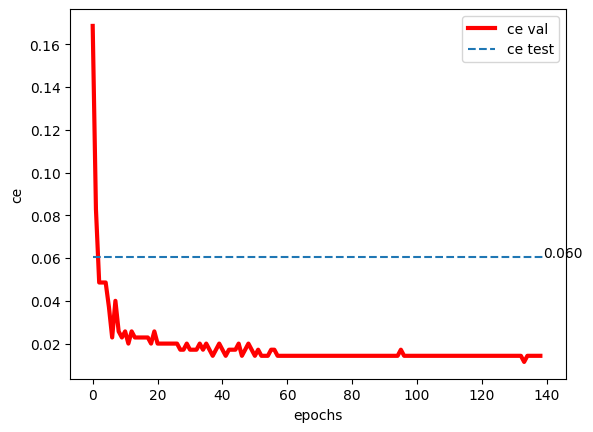

In [15]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    # result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    #this automatically saves the outputs in the folder where my assignment is located
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        # classnet = nn.Sequential(...)

        #three fully connected layers
        classnet = nn.Sequential(
        nn.Linear(D, M),   
        nn.ReLU(),         
        nn.Linear(M, M),   
        nn.ReLU(),         
        nn.Linear(M, M),  
        nn.ReLU(),         
        nn.Linear(M, K),  
        nn.LogSoftmax(dim=1)  
        )
        
        #
        # You are asked here to propose your own architecture
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        pass

    # CNN
    elif name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        # classnet = nn.Sequential(...)

        #one convolutional layer and two fully connected layers
        classnet = nn.Sequential(
        Reshape(size=(1, 8, 8)),                     
        nn.Conv2d(1, num_kernels, 3, padding=1),    
        nn.ReLU(),                                   
        nn.MaxPool2d(2),                            
        Flatten(),                                  
        nn.Linear(num_kernels * 4 * 4, M),           
        nn.ReLU(),                                   
        nn.Linear(M, K),                             
        nn.LogSoftmax(dim=1))

    
        # You are asked here to propose your own architecture
        # NOTE: Plese note that the images are represented as vectors, thus, you must
        # use Reshape(size) as the first layer, and Flatten() after all convolutional
        # layers and before linear layers.
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        pass

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: 

- MLP

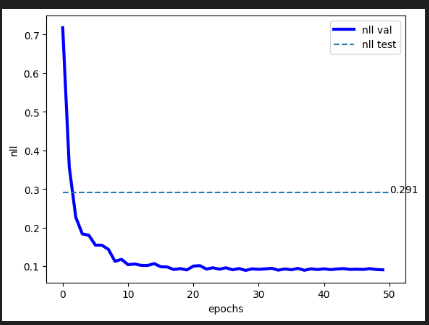

This image represents the results in terms of the loss function of the MLP model.

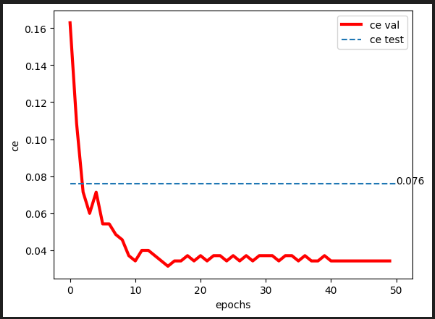

This image represents the results in terms of the classification error of the MLP model.

The starting loss function (NLL) was 0.718. Over epochs, the NLL drastically decreased. From the decrease we can conclude that that the model is improving and can minimise the loss. It acheived a value of 0.291 at the end. Furthermore, the starting classification error was 0.163 and the classification error also decreased over epochs. However, it had notable fluctuations indicating direct adjustment of weights in the steps. This is due to the simlicity of MLP. At the end, this model achieved a classification error 0.076, which is much lower than the starting error. Therefore, both the loss function and the classification error values decreased over time and achieved final values of 0.291 and 0.076 accordingly.

- CNN

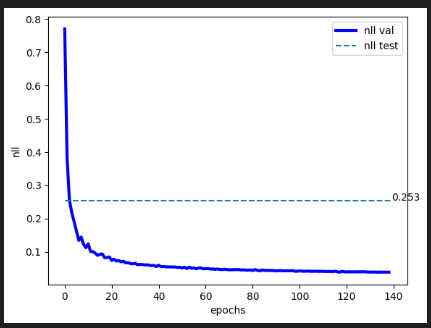

This image represents the results in terms of the loss function of the CNN model.

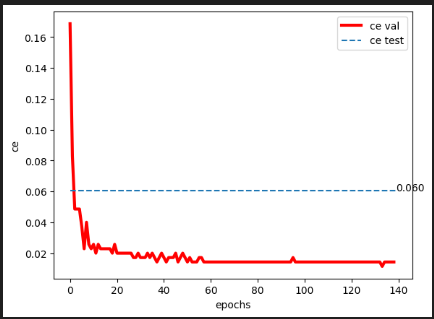

This image represents the results in terms of the classification error of the CNN model.

Similarlly to the MLP model, CNN model started of with quite high loss function value of 0.771. Over the epochs, the NLL value quickly decreased to the final value of 0.253. The ce decreased from starting value of 0.169 to the final value of 0.060 demonstrating the learning process of the model. Therefore, both the loss function and the classification error values decreased over time and achieved final values of 0.253 and 0.060 accordingly.

- Comparison

While both models achieved an optimal convergence values of 0.291, 0.253 for NLL and 0.076, 0.060 for ce, the convergence of CNN model was more smooth, but MLP converaged faster. The CNN model had less fluctuations in both- NLL and ce values. This could be explained by the fact that MLP models have fully connected layers and so the model can sometimes tend to overfit. Furthermore, MLP model do not have convolutional layers, which are beneficial in image classification. As a result, in such tasks as image classification- MLP may require less epochs to converge, uut the optimization process can become not-steady and sensitive to small changes in input data. 

**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: 

As mentioned in question 3, the CNN model did work slightly better than MLP for this specific task. While both algorithms can be used for simple image classification (based on the results in the previos tasks), the CNN model will outperform the MLP model in more complicated examples. This is due to the input values of both models. CNN takes a tensor as input, while MLP takes a vector. Tensors are decribing multilinear relationships and therefore, allow to take into account relations between nearby pixels in the image. This spatial relation, which also includes detection of edges, textures and other patterns, makes CNNs better for image classification. Also, as mentioned earlier, MLP is more sensitive to input. CNN is less sensitive because it does not use fully-connected layers and works locally, which allows it to learn more 'useful' features.

See the images below (MLP and CNN):

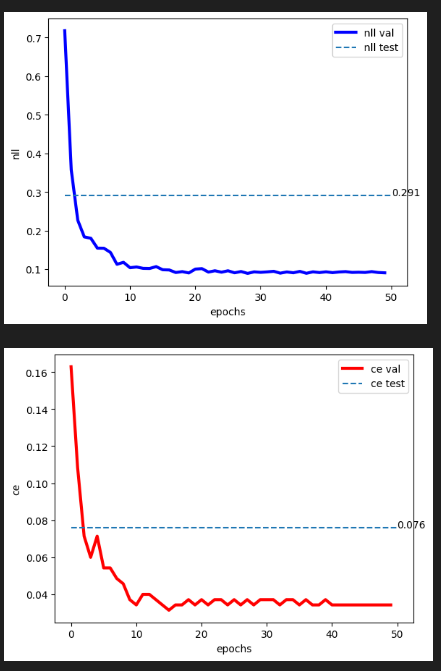 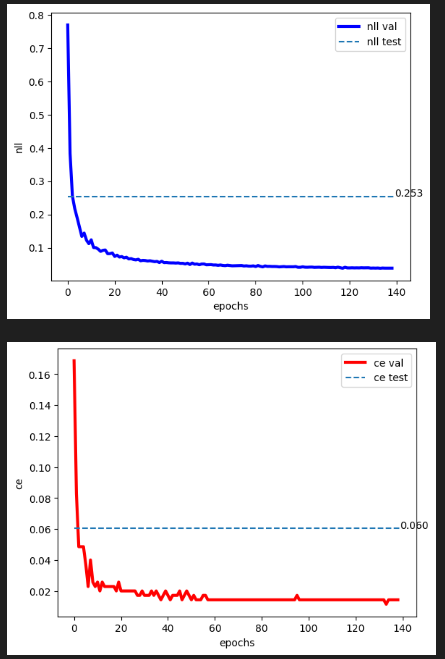


## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

In [28]:
#imports
from torchvision.datasets import SVHN
from torch.utils.data import Dataset

## 1. Dataset - splitting and loading
(1pt) Create appropriate Dataset class.

In [84]:

class SVHNDataset(Dataset):
    """Street View House Numbers (SVHN) dataset."""
    #this function is very similar to the function given at the beginning

    def __init__(self, root, mode="train", transforms=None, val_split=0.1):
        self.root = root
        self.mode = mode
        self.transforms = transforms
        self.dataset = SVHN(root=root, split="train", download=True)  
        
        if mode == "train":
            train_data, val_data, train_targets, val_targets = self.split_train_data(val_split)
            if self.mode == "train":
                self.data = train_data
                self.targets = train_targets
            elif self.mode == "val":
                self.data = val_data
                self.targets = val_targets
        else: 
            self.dataset = SVHN(root=root, split="test", download=True)
            self.data = self.dataset.data
            self.targets = self.dataset.labels

    #a helper function for splitting
    #the val split is the percentage of validation data used. 
    #it is set to 0.1, so 10% of train data will be val data and the rest 90% will be train data
    def split_train_data(self, val_split):
        num_train = len(self.dataset)
        indices = np.arange(num_train)
        np.random.shuffle(indices)
        split = int(np.floor(val_split * num_train))
        #spit the data
        train_idx, val_idx = indices[split:], indices[:split]
        train_data, train_targets = self.dataset.data[train_idx], self.dataset.labels[train_idx]
        val_data, val_targets = self.dataset.data[val_idx], self.dataset.labels[val_idx]

        return train_data, val_data, train_targets, val_targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx].astype(np.float32)
        sample_y = self.targets[idx]

        if self.transforms:
            sample_x = self.transforms(sample_x)

        return sample_x, sample_y




In [85]:
train_dataset = SVHNDataset(root="data", mode="train", transforms=None)
val_dataset = SVHNDataset(root="data", mode="val", transforms=None)
test_dataset = SVHNDataset(root="data" , mode="test", transforms=None)

Using downloaded and verified file: data\train_32x32.mat
Using downloaded and verified file: data\train_32x32.mat
Using downloaded and verified file: data\train_32x32.mat


In [86]:
training_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## 2. Implementation
(1pt) Implement an architecture that will give at most 0.1 classification error. 

I used the pytorch website (https://pytorch.org/docs/stable/nn.html) for improving the performance of previously designed cnn (adding more features and layers)


-> START SVHN_classifier_cnn
Epoch: 0, val nll=0.37793929540715726, val ce=0.10448148299821178
Epoch: 10, val nll=0.06660094240783745, val ce=0.013978186384918847
Epoch: 20, val nll=0.04450217909297669, val ce=0.007862729841516852
Epoch: 30, val nll=0.05156404535360872, val ce=0.00784907926887533
Epoch: 40, val nll=0.04613575151949311, val ce=0.007930982704724462
-> FINAL PERFORMANCE: nll=0.041775374021773976, ce=0.007985584995290552


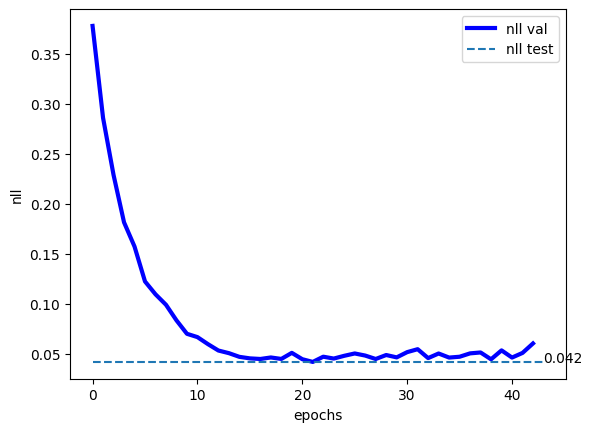

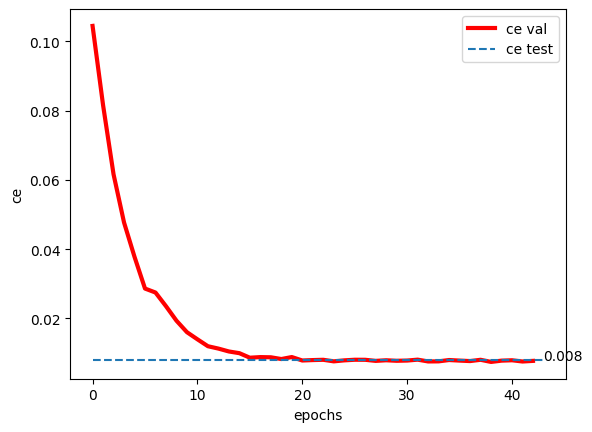

In [90]:
#repeat the code given before
names = ["SVHN_classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)


    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)


    # Define CNN architecture (this is a more complicated structure with more layers)
    classnet = nn.Sequential(
    #first convolutional layer
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    #activation- ReLU activation function applied in-place
    nn.ReLU(inplace=True),
    #batch normalization to normalize the previous outcome
    nn.BatchNorm2d(32),
    #2D max pooling layer 
    nn.MaxPool2d(kernel_size=2, stride=2),

    #seconf convolutional layer
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    #activation- ReLU activation function applied in-place
    nn.ReLU(inplace=True),
    #batch normalization to normalize the previous outcome
    nn.BatchNorm2d(64),
    #2D max pooling layer 
    nn.MaxPool2d(kernel_size=2, stride=2),

    #flatten function to convert multi-dimensional tensor into one-dimensional tensor
    nn.Flatten(),

    #first fully connected layer
    nn.Linear(64 * 8 * 8, 512),
    #activation- ReLU activation function applied in-place
    nn.ReLU(inplace=True),

    #EXTRA COMPONENT:
    #dropout with a probability of 0.5 
    nn.Dropout(0.5),

    #second fully connected layer
    nn.Linear(512, 10),
    
    nn.LogSoftmax(dim=1)
)

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )
    num_epochs = 70  
    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )


## 3. Extra component
(1pt) Think of an extra component that could improve the performance 
- Regularization methods: for example, L2 regularization, dropout.

nn.Dropout(probability)

I used the dropout component in my code. This regularization method works well as an extra component for improving the performance of cnn for image classification. Dropout is deactivating ('dropping') a specific amount of data to avoid overfitting, which may occur when the model learns to memorize the training data too much. This makes the performance of the model less fluctuating and more stable, leading to better performance of unseen data. 

- Optimization methods: for example, stochastic gradient descent

optimizer = torch.optim.SGD()

This gradient descent algorithm updates the parameters of the model based on the gradients of the loss function with respect to those parameters. This component could help to acheive faster convergence due to parameter updates. Additionally, another component that could imorove the performance of CNN for image classification would be adapting the learning rate at each step based on intermediate results.

## 4. Explanation & Description of architecture
(1pt) Provide a good explanation of the applied architecture and a description of all components.

Explanation of the applied architecture:

1. First convolutional layer: nn.Conv2d(3, 32, kernel_size=3, padding=1)
   - This is the very first layer of the CNN architecture
   - It takes an input image with three colors (red, green, blue)
   - It applies 32 kernels (filters) of size 3x3 to the input image
   - It applies padding to deal with dimensions a
   - 32 is the number of feature maps

2. ReLU activation (nn.ReLU(inplace=True))
   - ReLU is an activation applied after the first convolutional layer
   - ReLU is added for dealing with non-linearity by replacing negative values with 0

3. Batch normalization (nn.BatchNorm2d(32))
   - Batch normalization is applied after the ReLU activation mentioned before
   - It normalizes the activations of the previous layer
   - This helps with improving the stability and speed

4. Max pooling layer (nn.MaxPool2d(kernel_size=2, stride=2))
   - The pooling layer follows the first convolutional layer and batch normalization
   - It performs 2x2 max pooling with a stride of 2
   - It reduces the spatial dimensions

5. Second convolutional layer (nn.Conv2d(32, 64, kernel_size=3, padding=1))
   - This is the second layer of the CNN architecture
   - It takes the 32 filters from the layer before as input
   - It applies 64 filters of size 3x3 with padding 1
   - It outputs 64 feature maps

6. ReLU activation (nn.ReLU(inplace=True))
   - Right after the second convolutional layer (see the explanation of the first ReLU after the first conv-layer)

7. Batch normalization (nn.BatchNorm2d(64))
   - Right after ReLU activation (see the explanation of the first batch normalization after the first ReLU)

8. Max pooling layer (nn.MaxPool2d(kernel_size=2, stride=2))
   - Another pooling layer following the second convolutional layer and batch normalization (see the explanation of the first max pooling after the first batch normalization)

9. Flattening (nn.Flatten())
   - It is applied after the final convolutional layer and pooling layer
   - Used to converts multi-dimensional attributes into a one-dimensional tensor
   - This is done to prepare the data for the fully connected layers

10. First fully connected layer (nn.Linear(64 * 8 * 8, 512))
    - This is the first fully connected layer
    - The output size is 512 units (hidden representation)

11. ReLU activation (nn.ReLU(inplace=True))
    - Applied after the first fully connected layer
    - Used for non-linearity to the network

12. Dropout (nn.Dropout(0.5))
    - Regularization method
    - Dropout with a probability of 0.5
    - The probability of 0.5 was added to balance between dropping and not dropping a value 
    - Deactivates (randomly) neurons during training to prevent overfitting

13. Second fully connected layer (nn.Linear(512, 10))
    - The second and final fully connected layer
    - Gives the final outputs, which are corresponding to the class scores for the 10 output classes

14. LogSoftmax activation (nn.LogSoftmax(dim=1))
    - Converts the outputs from previous layer into probabilities for each class using the logarithm of the softmax function




The following components were used:
1) Convolutional layers
The basic layers of CNNs. Used to obtain features from input images.
2) ReLU activations
Activation functions introduce non-linearity. The inplace was set to true so that the modification of the input tensor is done in place and a new tensor is not created for each activation function computation.
3) Batch normalizations
Batch normalizations is used for normalization of activations. This is helpful for stabiliztion and allows for higher learning rates.
4) Max pooling layers
Max pooling layers take sections of the feature maps produced by the convolutional layers and keep only the max value from each section. It helps the model focus on the more important features and makes it less sensitive to small changes in the input images.
5) Dropout
Dropout is a regularization method which is used to avoid overfitting. This is done by not relying on individual values but learning robust features. The inut (probability) can be adjusted.
6) Fully connected layers
Fully connected layers perform classification by taking into account information from convolutional layers. The output are class scores for each output class.


## Results Analysis

(2pt) Analyze the results.

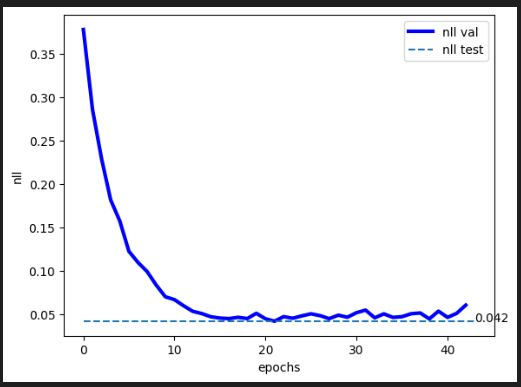

This image represents the results in terms of the loss function of the CNN model.

The NLL quickly decreased during the initial epochs from 0 to 10, this means that the model is learning quickly and improving its performance. After, the loss function stabilizes and continues to decrease more slowly. However, there are some fluctuations indicating small changes in the loss function values. The final test NLL value is 0.042.

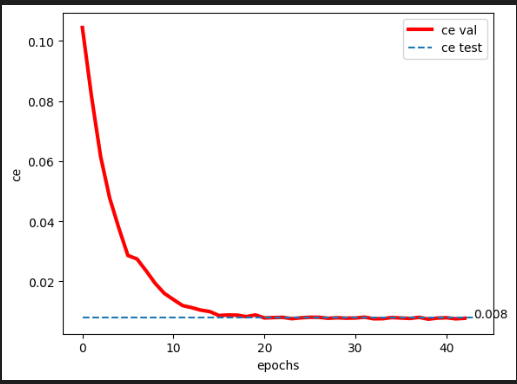

This image represents the results in terms of the classification error of the CNN model.

Similarly to the NLL, the ce decreased rapidly during the first 10 epochs, indicating great learning and improvement in classification accuracy. After approximately 10 epochs, the classification error stabilizes and continues to decrease more slowly and is smooth and stable. The final test ce value is 0.008.

Overall, the low and stable values of both loss function and classification error indicate that the model generalizes well to unseen data, avoiding overfitting.